# Analysis of an optimal solution

In [170]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx
from ItalySetup import ItalySetup
from covidOCP import COVIDVaccinationOCP, COVIDParametersOCP
from main import pick_scenario, build_scenario
import seaborn as sns
import datetime
import pickle

nx = 9
states_names = ['S', 'E', 'P', 'I', 'A', 'Q', 'H', 'R', 'V']

when = 'future'
file_prefix = f'week'

nnodes = 107  # nodes
ndays = 90

setup = ItalySetup(nnodes, ndays, when)
M = setup.nnodes
N = len(setup.model_days) - 1

with open(f'italy-data/parameters_{nnodes}_{when}.pkl', 'rb') as inp:
    p = pickle.load(inp)

Loaded Italy Setup with 107 nodes.


In [171]:
filename = 'model_output/scenarios/L-r15-t479700-id17-opi-107_180.csv'
md = pd.read_csv(filename, index_col= 'date', parse_dates=True)
baseline_fn = 'model_output/scenarios/L-r1-t125000-id1-novacc-107_180.csv'
bl = pd.read_csv(baseline_fn, index_col= 'date', parse_dates=True)

In [177]:
dates_interm = pd.date_range(setup.start_date, setup.end_date, freq='15D')
dates_interm

DatetimeIndex(['2021-01-01', '2021-01-16', '2021-01-31', '2021-02-15',
               '2021-03-02', '2021-03-17'],
              dtype='datetime64[ns]', freq='15D')

In [179]:
G = networkx.Graph()
G.position = {}
G.population = {}
G.comp = {}
G.epi = {}
setup.shp['vacc'] = np.nan
setup.shp['Rend'] = np.nan
for i, node in enumerate(setup.ind2name):
    G.add_node(node)
    G.position[node] = (setup.pos_node[i,0], setup.pos_node[i,1])
    G.population[node] = setup.pop_node[i]
    mdp = md[md['place']==node]
    blp = bl[bl['place']==node]
    
    total_vacc = mdp[ mdp['comp']=='vacc']['value'].sum()
    Rend       = mdp[ mdp['comp']=='R']['value'][-1]
    ndays_vacc = len(mdp[(mdp['comp']=='vacc') & (mdp['value']>1)])
    total_inf  = mdp[ mdp['comp'].isin(['E', 'P', 'I', 'A', 'Q', 'H', 'R']) & (mdp.index == str(setup.end_date))]['value'].sum()
    new_inf    = mdp[ mdp['comp']=='yell']['value'].sum() # mdp[ mdp['comp'].isin(['E', 'P', 'I', 'A']) & (mdp.index == str(setup.end_date))]['value'].sum()
    new_inf_bl = blp[ blp['comp']=='yell']['value'].sum()
    
    
    G.epi[node] = {'total_vacc': total_vacc,
                   'Rend':       Rend,
                   'ndays_vacc': ndays_vacc,
                   'total_inf':  total_inf,
                   'new_inf':    new_inf,
                   'new_inf_bl': new_inf_bl}
    setup.shp.loc[i, 'total_vacc'] = total_vacc
    setup.shp.loc[i, 'Rend'] =       Rend
    setup.shp.loc[i, 'ndays_vacc'] = ndays_vacc
    setup.shp.loc[i, 'total_inf'] =  total_inf
    setup.shp.loc[i, 'new_inf'] =    new_inf
    setup.shp.loc[i, 'new_inf_bl'] =    new_inf_bl
    setup.shp.loc[i, 'population'] = setup.pop_node[i] # overwrite 
    for dt in dates_interm:
        setup.shp.loc[i, f'total_vacc{str(dt.date())}'] = mdp[(mdp['comp']=='vacc') & (mdp.index < dt)]['value'].sum()
    
    for j, connection in enumerate(p.mobmat_pr[i]):
        if connection != 0:
            G.add_edge(node, setup.ind2name[j], weight=connection)
G.number_of_edges()

366

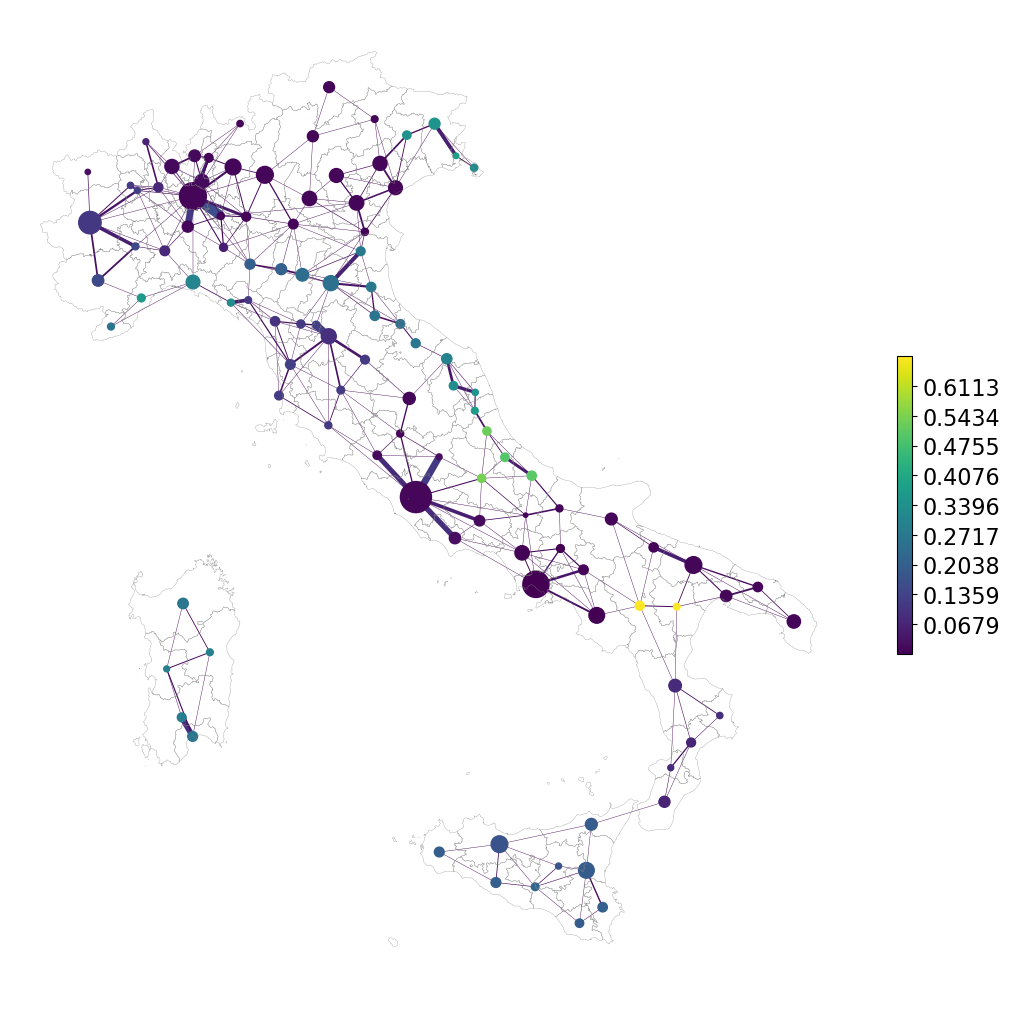

In [174]:
fig, ax = plt.subplots(1,1,figsize=(10, 10), dpi=100, constrained_layout=True) #


networkx.draw(G, 
          G.position, 
          node_size=500/max(setup.pop_node) * np.array([G.population[v] for v in G]),
          #node_color=[float(G.degree(v)) for v in G],
          #node_color=[G.population[v] for v in G],
          #node_color=[G.epi[v]['vacc']/G.population[v] for v in G],
          node_color= [G.epi[v]['total_vacc']/G.population[v] for v in G],
          width = 30* np.array([max(a['weight'],0.01) for u,v,a in G.edges(data=True)]),
          edge_color= 10 * np.array([a['weight'] for u,v,a in G.edges(data=True)]),
          edge_cmap = mpl.cm.viridis,
        cmap = mpl.cm.viridis,
          ax = ax,
         with_labels=False
       )

#     # scale the axes equally
plt.xlim(min(setup.pos_node[:,0]) - 100000, max(setup.pos_node[:,0])+ 100000)
plt.ylim(min(setup.pos_node[:,1]) - 100000, max(setup.pos_node[:,1])+ 100000)

#s.shp.plot(ax = ax, column='' cmap='OrRd', facecolor="none", edgecolor="black")

setup.shp.boundary.plot(ax = ax,  edgecolor="grey", linewidth = .2)


cmap = mpl.cm.viridis#sns.cm.rocket
vmin = min([G.epi[v]['total_vacc']/G.population[v] for v in G])
vmax = max([G.epi[v]['total_vacc']/G.population[v] for v in G])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
#sm._A = []
cmap = fig.colorbar(sm, ax=ax, shrink=.3,  ticks=np.arange(0, vmax, vmax/10),location = 'right')

cmap.ax.set_yticklabels(['{:.4f}'.format(x) for x in np.arange(0, vmax,vmax/10)], fontsize=16)#, weight='bold')

plt.draw()
fig.savefig('figures/map_nd.pdf')

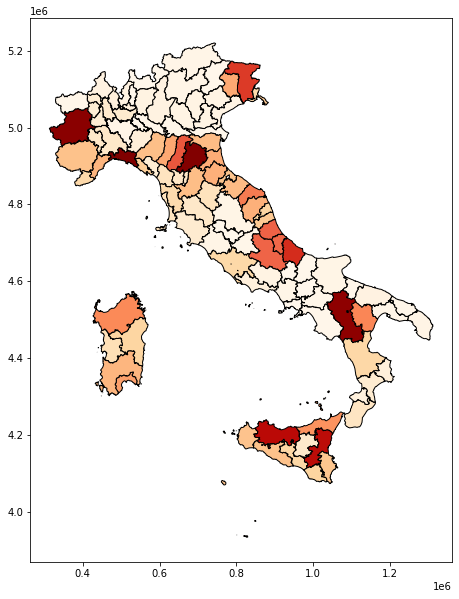

In [175]:
fig, ax = plt.subplots(1,1,figsize=(10, 10))
setup.shp.plot(ax = ax, column='total_vacc', cmap='OrRd',  edgecolor="black"); #facecolor="none",

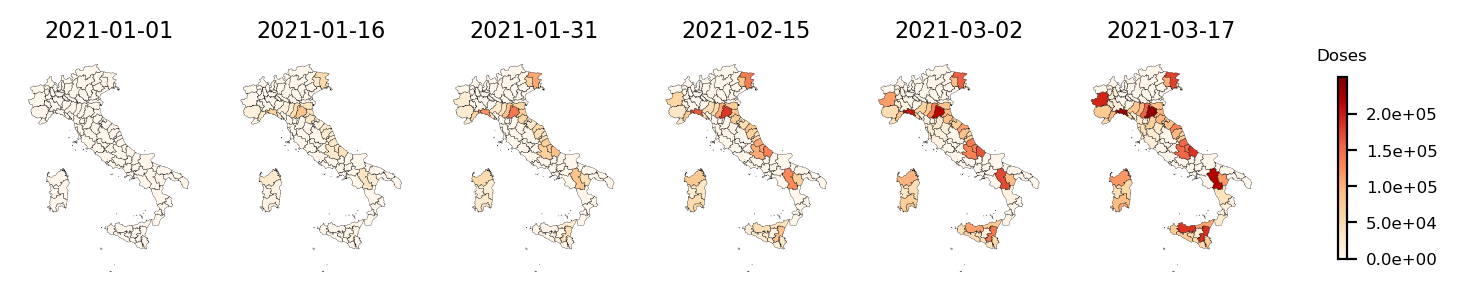

In [193]:
fig, ax = plt.subplots(1, len(dates_interm),figsize=(10, 30), dpi = 200)

cmap = mpl.cm.OrRd #viridis  #sns.cm.rocket  'OrRd'
vmin = 0
vmax = 2.5e5#max(setup.shp.total_vacc)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
cmap = fig.colorbar(sm, ax=ax.ravel().tolist(), shrink=.04, ticks=np.arange(0, vmax, vmax/5))
cmap.ax.set_title('Doses', fontsize=6)

for i, dt in enumerate(dates_interm):
    setup.shp.plot(ax = ax.flat[i], column=f'total_vacc{str(dt.date())}', 
                          edgecolor="black", lw = .1, cmap = 'OrRd', vmin=vmin, vmax=vmax)
    #facecolor="none",
    ax.flat[i].axis('off')
    ax.flat[i].set_title(str(dt.date()), fontsize = 8)
#fig.subplots_adjust(right=0.8)
# put colorbar at desire position
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(im, cax=cbar_ax)
#fig.colorbar(ax.flat[i])
cmap.ax.set_yticklabels(['{:.1e}'.format(x) for x in np.arange(0, vmax,vmax/5)], fontsize=6);#, weight='bold')
fig.savefig('figures/map_tf.pdf')

In [185]:
max(setup.shp.total_vacc)

257010.71131244302

In [186]:
1e5

100000.0

In [99]:
vmax/

0.5744113734157691

57441.137341576905

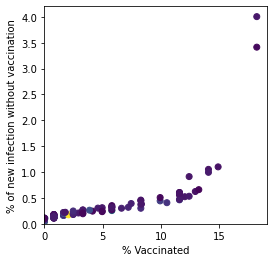

In [155]:
import seaborn as sns
fig, ax = plt.subplots(1,1,figsize=(4, 4))
plt.scatter(setup.shp['total_vacc']/setup.shp['population']*100, setup.shp['new_inf_bl']/setup.shp['population']*100, c= setup.shp['population'])
ax.set_xlabel("% Vaccinated")
ax.set_ylabel("% of new infection without vaccination");
ax.set_xlim(0)
ax.set_ylim(0)
fig.savefig('figures/scatter_vacc_inf.pdf')

/Users/chadi/opt/miniconda3/envs/ocp-covid/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


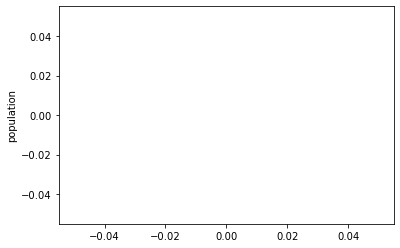

In [17]:
ax = sns.scatterplot(setup.shp['vacc'], setup.shp['population'], hue=setup.shp['Rend'])
ax.get_legend().remove();
#ax.set(xscale="log", yscale="log")

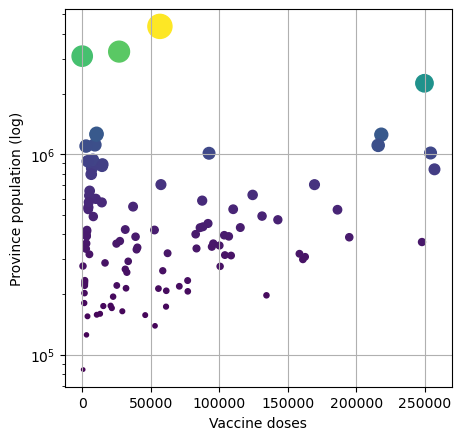

In [194]:
fig, ax = plt.subplots(figsize=(5,5), dpi = 100)
ax.scatter(setup.shp['total_vacc'], 
           setup.shp['population'],
           s=setup.shp.population/max(setup.shp.population)*300, 
           c=setup.shp.population/max(setup.shp.population)*300)
#ax.get_legend().remove();
ax.grid()
ax.set_ylabel('Province population (log)')
ax.set_xlabel('Vaccine doses')
ax.set(yscale="log") 
fig.savefig('figures/scatter_vacc_pop.pdf')

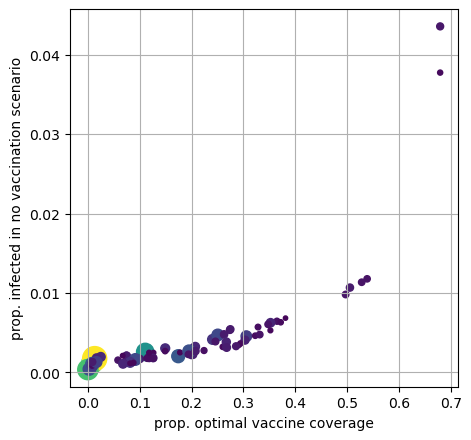

In [195]:
fig, ax = plt.subplots(figsize=(5,5), dpi = 100)
ax.scatter(setup.shp['total_vacc']/setup.shp['population'], 
           setup.shp['new_inf_bl']/setup.shp['population'], 
           s=setup.shp.population/max(setup.shp.population)*300, 
           c=setup.shp.population/max(setup.shp.population)*300)
#ax.get_legend().remove();
ax.grid()
#ax.set( yscale="log", xscale="log") #
ax.set_xlabel('prop. optimal vaccine coverage')
ax.set_ylabel('prop. infected in no vaccination scenario')
fig.savefig('figures/scatter_vacc_inf.pdf')

/Users/chadi/opt/miniconda3/envs/ocp-covid/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


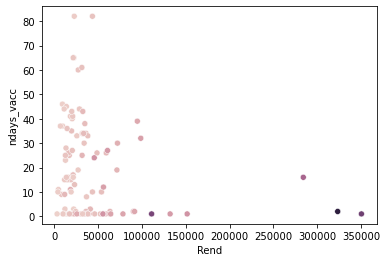

In [196]:
ax = sns.scatterplot(setup.shp['Rend'], setup.shp['ndays_vacc'], hue=setup.shp['population'])
ax.get_legend().remove();

In [202]:
setup.shp.columns

Index(['COD_RIP', 'COD_REG', 'COD_PROV', 'COD_CM', 'COD_UTS', 'DEN_PROV',
       'DEN_CM', 'DEN_UTS', 'SIGLA', 'TIPO_UTS', 'Shape_Leng', 'Shape_Area',
       'geometry', 'name', 'population', 'mobile_fraction', 'vacc', 'Rend',
       'total_vacc', 'ndays_vacc', 'total_inf', 'new_inf', 'new_inf_bl',
       'total_vacc2021-01-01', 'total_vacc2021-01-10', 'total_vacc2021-01-19',
       'total_vacc2021-01-28', 'total_vacc2021-02-06', 'total_vacc2021-02-15',
       'total_vacc2021-02-24', 'total_vacc2021-03-05', 'total_vacc2021-03-14',
       'total_vacc2021-03-23', 'total_vacc2021-01-16', 'total_vacc2021-01-31',
       'total_vacc2021-03-02', 'total_vacc2021-03-17'],
      dtype='object')

In [234]:
df = setup.shp

df = df.sort_values('total_vacc', ascending=False)
df = df[df.columns[13:]]
df[df.columns[2:]]/np.arange(107).T

ValueError: Unable to coerce to Series, length must be 22: given 107

In [235]:
df.shape

(107, 24)

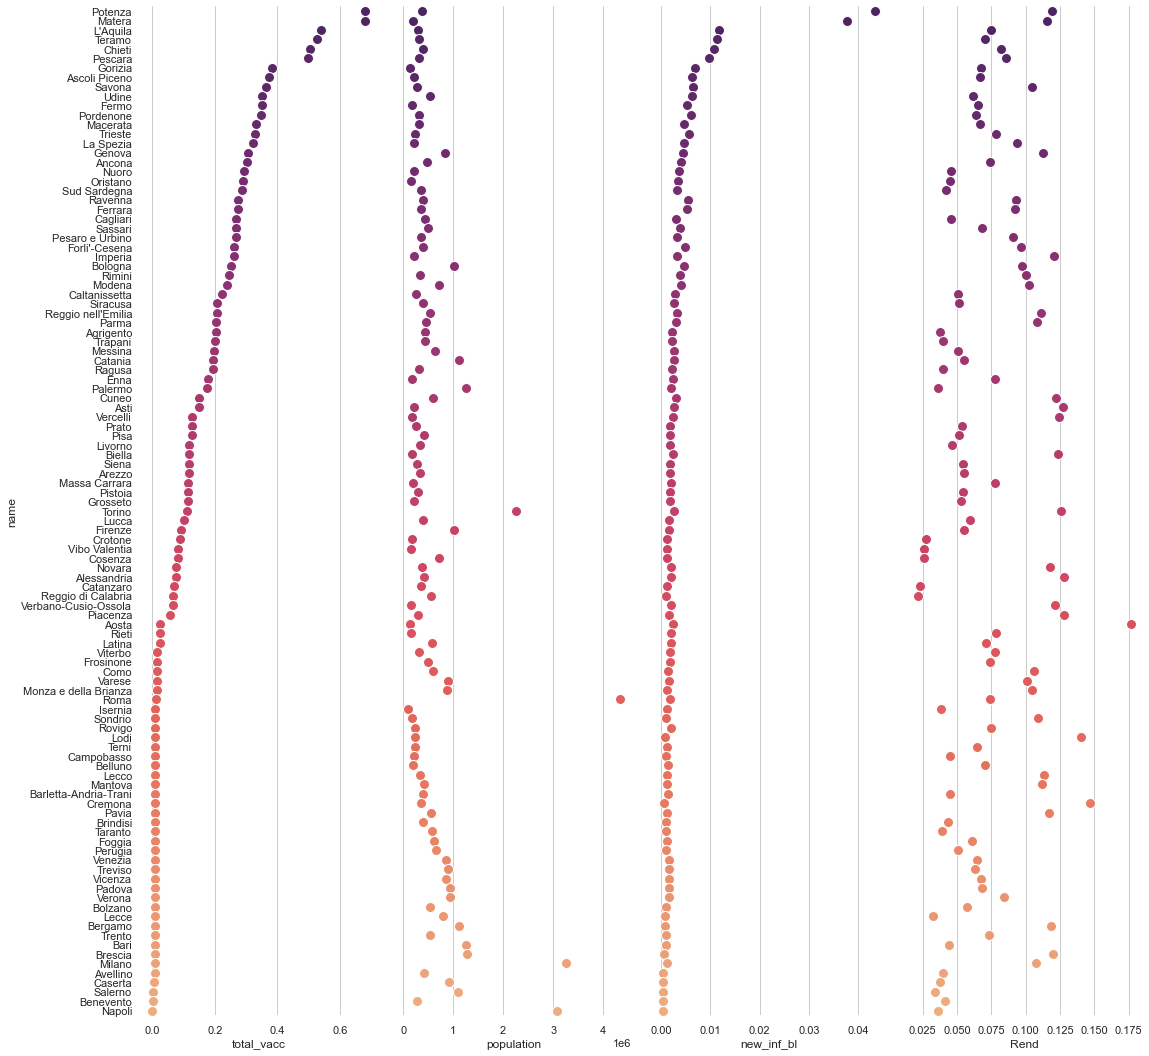

In [236]:
import seaborn as sns
sns.set_theme(style="whitegrid")

df = setup.shp

df = df.sort_values('total_vacc', ascending=False)
df = df[df.columns[13:]]

for col in df.columns[2:]:
    df[col] = df[col]/df.population

# Make the PairGrid
g = sns.PairGrid(df.sort_values('total_vacc', ascending=False),
                 x_vars=['total_vacc', 'population', 'new_inf_bl', 'Rend'], y_vars=["name"],
                 height=15, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
#g.set(xlim=(0, 25), xlabel="Crashes", ylabel="")

# Use semantically meaningful titles for the columns
#titles = ["Total crashes", "Speeding crashes", "Alcohol crashes",
#          "Not distracted crashes", "No previous crashes"]

#for ax, title in zip(g.axes.flat, titles):#

#    # Set a different title for each axes
#    ax.set(title=title)

    # Make the grid horizontal instead of vertical
#    ax.xaxis.grid(False)
#    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)